# Object Detection Example

## Introduction

In this notebook, we'll walk through a detailed example of how you can use Valor to evaluate object detections made on [the COCO Panoptic dataset](https://cocodataset.org/#home). We'll use Ultralytics' `YOLOv8` model to predict what objects exist in various COCO photographs and compare performance between bounding box and image segmentation results.

For a conceptual introduction to Valor, [check out our project overview](https://striveworks.github.io/valor/). For a higher-level example notebook, [check out our "Getting Started" notebook](https://github.com/Striveworks/valor/blob/main/examples/getting_started.ipynb).

## Defining Our Datasets

We start by fetching our dataset and uploading it to Valor.

In [1]:
%matplotlib inline

import os
import json
import builtins
import requests

from tqdm import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from valor_lite.object_detection import DataLoader, MetricType, Detection, BoundingBox

In [2]:
def download_data_if_not_exists(
    file_name: str,
    file_path: Path,
    url: str,
):
    """Download the data from a public bucket if it doesn't exist locally."""

    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get("content-length", 0))
            with open(file_path, "wb") as f:
                with tqdm(
                    total=total_size,
                    unit="B",
                    unit_scale=True,
                    unit_divisor=1024,
                    desc=file_name,
                ) as pbar:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                            pbar.update(1024)
        else:
            raise RuntimeError(response)
    else:
        print(f"{file_name} already exists locally.")

    # sort file by datum uid
    with open(file_path, "r") as f:
        lines = [x for x in f]
    with open(file_path, "w") as f:
        for line in sorted(
            lines, key=lambda x: int(json.loads(x)["datum"]["uid"])
        ):
            f.write(line)

groundtruth_file = "gt_objdet_coco_bbox.jsonl"
prediction_file = "pd_objdet_yolo_bbox.jsonl"

# cache data locally
current_directory = Path(os.getcwd())
for filename in [groundtruth_file, prediction_file]:
    file_path = current_directory / Path(filename)
    url = f"https://pub-fae71003f78140bdaedf32a7c8d331d2.r2.dev/{filename}"
    download_data_if_not_exists(
        file_name=filename, file_path=file_path, url=url
    )

gt_path = current_directory / Path(groundtruth_file)
pd_path = current_directory / Path(prediction_file)

gf = builtins.open(gt_path, "r")
groundtruths = [
    json.loads(gline)
    for gline in gf
]
gf.close()

pf = builtins.open(pd_path, "r")
predictions = [
    json.loads(pline)
    for pline in pf
]
pf.close()

gt_objdet_coco_bbox.jsonl already exists locally.
pd_objdet_yolo_bbox.jsonl already exists locally.


In [3]:
def _get_bbox_extrema(
    data: list,
) -> tuple[float, float, float, float]:
    """Get the bounding box coordinates from a valor Annotation object."""
    x = [point[0] for shape in data for point in shape]
    y = [point[1] for shape in data for point in shape]
    return (min(x), max(x), min(y), max(y))


def _convert_valor_dicts_into_detection(gt_dict: dict, pd_dict: dict):
    """Convert a groundtruth dictionary and prediction dictionary into a valor_lite Detection object."""
    gts = []
    pds = []

    for gann in gt_dict["annotations"]:
        labels = []
        for valor_label in gann["labels"]:
            # NOTE: we only include labels where the key is "name"
            if valor_label["key"] != "name":
                continue

            labels.append(valor_label["value"])

        # if the annotation doesn't contain any labels that aren't key == 'name', then we skip that annotation
        if not labels:
            continue

        x_min, x_max, y_min, y_max = _get_bbox_extrema(gann["bounding_box"])

        gts.append(
            BoundingBox(
                xmin=x_min,
                xmax=x_max,
                ymin=y_min,
                ymax=y_max,
                labels=labels,
            )
        )

    for pann in pd_dict["annotations"]:
        labels, scores = [], []
        for valor_label in pann["labels"]:
            if valor_label["key"] != "name":
                continue
            labels.append(valor_label["value"])
            scores.append(valor_label["score"])
        if not labels:
            continue

        x_min, x_max, y_min, y_max = _get_bbox_extrema(pann["bounding_box"])

        pds.append(
            BoundingBox(
                xmin=x_min,
                xmax=x_max,
                ymin=y_min,
                ymax=y_max,
                labels=labels,
                scores=scores,
            )
        )

    return Detection(
        uid=gt_dict["datum"]["uid"],
        groundtruths=gts,
        predictions=pds,
    )

# Creating an Evaluator

This block utilizes `get_instance_groundtruths` from `integrations/coco_integration.py` to download, extract, and upload the COCO Panoptic validation dataset to Valor.

In [4]:
loader = DataLoader()
loader.add_bounding_boxes(
    [
        _convert_valor_dicts_into_detection(gt, pd)
        for gt, pd in zip(groundtruths, predictions)
    ],
    show_progress=True,
)
evaluator = loader.finalize()

100%|██████████| 5000/5000 [00:00<00:00, 8122.07it/s]


In [5]:
evaluator.metadata

{'n_datums': 5000,
 'n_groundtruths': 36536,
 'n_predictions': 27092,
 'n_labels': 80,
 'ignored_prediction_labels': [],
 'missing_prediction_labels': ['hair drier']}

## Evaluating Performance

With our `Dataset` and `Model` defined, we're ready to evaluate our performance and display the results. Note that we use the `wait_for_completion` method since all evaluations run as background tasks; this method ensures that the evaluation finishes before we display the results.

Sometimes, we may only want to calculate metrics for a subset of our data (i.e., we may only want to see how well our model performed at a specific type of detection). To accomplish this task, we can use the `filters` parameter of `evaluation_detection` to specify what types of data to evaluate performance for.

We will be running and comparing two different evaluations investigating the performance difference of YOLOv8's bounding box and raster outputs.

In [6]:
metrics = evaluator.evaluate(
    iou_thresholds=[0.25],
)

### Average Precision (AP)

In [7]:
metrics[MetricType.AP]

[Metric(type='AP', value=0.03931711480949181, parameters={'iou_threshold': 0.25, 'label': 'person'}),
 Metric(type='AP', value=0.00574667500702136, parameters={'iou_threshold': 0.25, 'label': 'chair'}),
 Metric(type='AP', value=0.012869301715994604, parameters={'iou_threshold': 0.25, 'label': 'potted plant'}),
 Metric(type='AP', value=0.12468056653228336, parameters={'iou_threshold': 0.25, 'label': 'dining table'}),
 Metric(type='AP', value=0.025555256805287804, parameters={'iou_threshold': 0.25, 'label': 'tv'}),
 Metric(type='AP', value=0.0873892652423137, parameters={'iou_threshold': 0.25, 'label': 'microwave'}),
 Metric(type='AP', value=0.07156154587928347, parameters={'iou_threshold': 0.25, 'label': 'refrigerator'}),
 Metric(type='AP', value=0.0, parameters={'iou_threshold': 0.25, 'label': 'book'}),
 Metric(type='AP', value=0.017410438586802798, parameters={'iou_threshold': 0.25, 'label': 'clock'}),
 Metric(type='AP', value=0.01582175783225678, parameters={'iou_threshold': 0.25, 'l

### Mean Average Precision (mAP)

In [8]:
metrics[MetricType.mAP]

[Metric(type='mAP', value=0.049578458401377326, parameters={'iou_threshold': 0.25})]

### Precision-Recall Curve

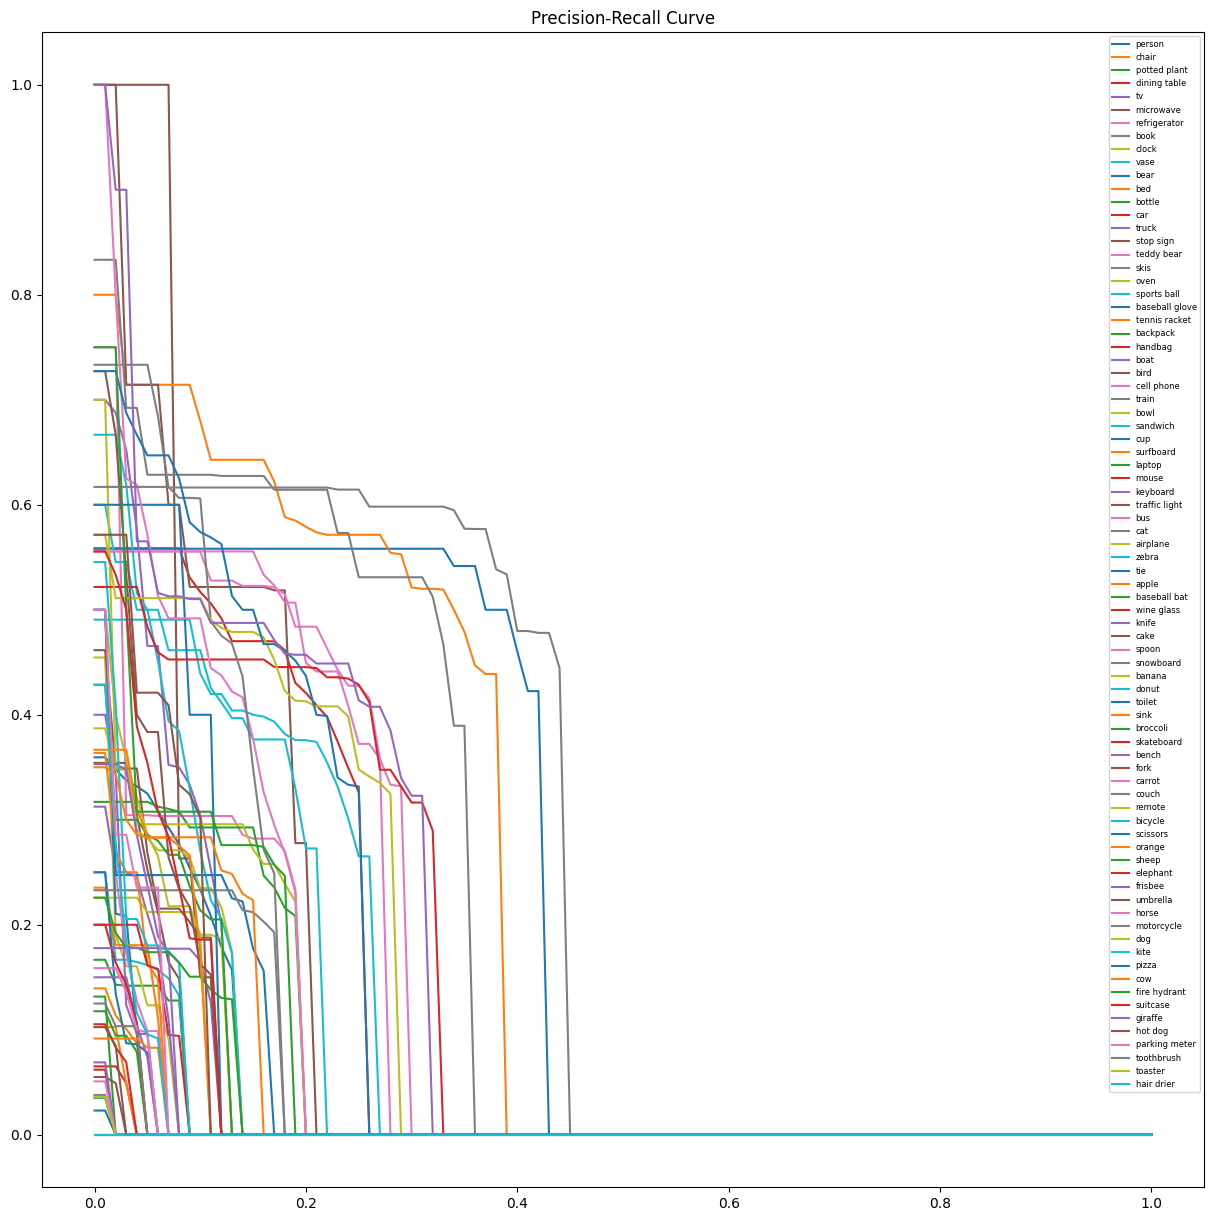

In [9]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
recall = [x / 100 for x in range(0,101)]
for curve in metrics[MetricType.PrecisionRecallCurve]:
    plt.plot(
        recall, 
        curve.value["precisions"],
        label=curve.parameters["label"],
    )
plt.title("Precision-Recall Curve")
plt.legend(prop={'size': 6})
plt.show()

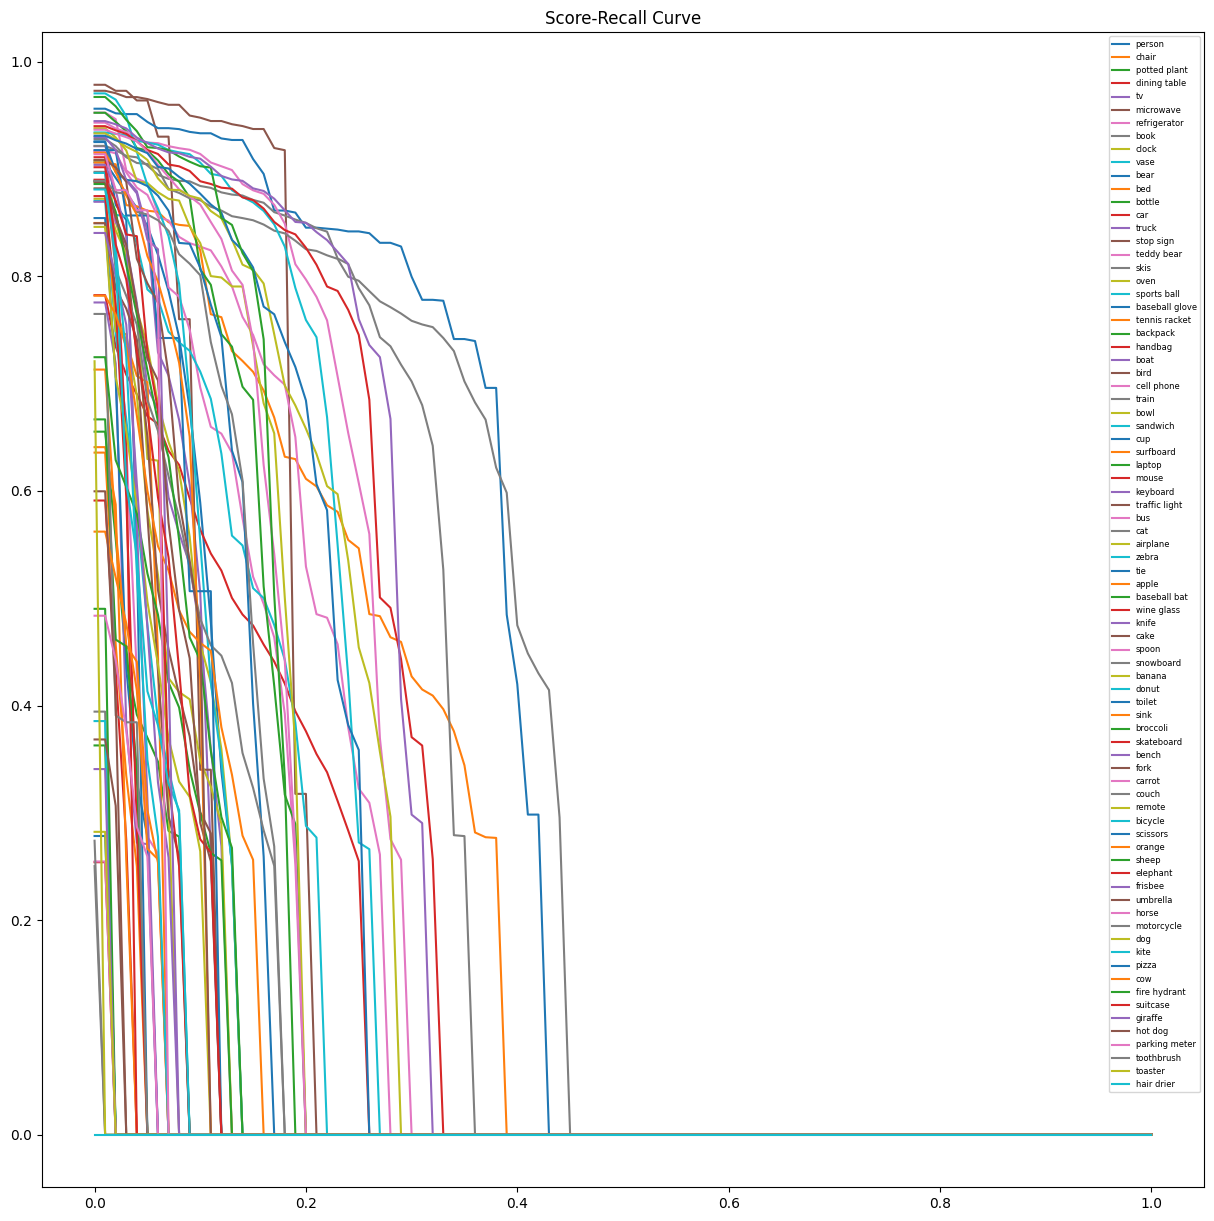

In [10]:
# Plot scores over recall

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
recall = [x / 100 for x in range(0,101)]
for curve in metrics[MetricType.PrecisionRecallCurve]:
    plt.plot(recall, curve.value["scores"], label=curve.parameters["label"])
plt.title("Score-Recall Curve")
plt.legend(prop={'size': 6})
plt.show()

### Confusion Matrix

In [11]:
matrices = evaluator.evaluate(
    score_thresholds=[0.25],
    iou_thresholds=[0.25],
    number_of_examples=3,
)[MetricType.ConfusionMatrix]
metric = matrices[0]

metric.value["confusion_matrix"]["person"]["person"]["examples"]

[{'datum': '872',
  'groundtruth': {'xmin': 126.0, 'xmax': 606.0, 'ymin': 164.0, 'ymax': 428.0},
  'prediction': {'xmin': 156.0, 'xmax': 425.0, 'ymin': 129.0, 'ymax': 608.0},
  'score': 0.7444794178009033},
 {'datum': '872',
  'groundtruth': {'xmin': 101.0, 'xmax': 557.0, 'ymin': 145.0, 'ymax': 436.0},
  'prediction': {'xmin': 294.0, 'xmax': 435.0, 'ymin': 101.0, 'ymax': 592.0},
  'score': 0.595190167427063},
 {'datum': '885',
  'groundtruth': {'xmin': 190.0, 'xmax': 397.0, 'ymin': 277.0, 'ymax': 416.0},
  'prediction': {'xmin': 277.0, 'xmax': 418.0, 'ymin': 186.0, 'ymax': 397.0},
  'score': 0.9295347929000854}]

In [12]:
cm = {
    gt: {
        pd: metric.value["confusion_matrix"][gt][pd]["count"]
        for pd in metric.value["confusion_matrix"][gt]
    }
    for gt in metric.value["confusion_matrix"]
}
pd.DataFrame(cm)

,person,chair,potted plant,dining table,tv,microwave,refrigerator,book,clock,vase,...,pizza,cow,fire hydrant,suitcase,giraffe,hot dog,parking meter,toothbrush,toaster,hair drier
person,1718,23,4,35,3,0,0,2,0,1,...,9,2,1,4,0,4,0,1,0,1
chair,11,97,2,5,3,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
potted plant,1,4,31,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dining table,35,7,3,186,1,0,0,1,0,0,...,4,0,0,0,0,1,0,0,0,0
tv,2,3,0,0,35,1,1,3,2,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hot dog,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0
parking meter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
toothbrush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
toaster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Hallucinations

In [13]:
metric.value["hallucinations"]

{'person': {'count': 7483,
  'examples': [{'datum': '139',
    'prediction': {'xmin': 416.0, 'xmax': 465.0, 'ymin': 157.0, 'ymax': 295.0},
    'score': 0.7308055758476257},
   {'datum': '785',
    'prediction': {'xmin': 278.0, 'xmax': 502.0, 'ymin': 43.0, 'ymax': 394.0},
    'score': 0.9136597514152527},
   {'datum': '885',
    'prediction': {'xmin': 595.0, 'xmax': 639.0, 'ymin': 26.0, 'ymax': 250.0},
    'score': 0.8734474778175354}]},
 'chair': {'count': 837,
  'examples': [{'datum': '139',
    'prediction': {'xmin': 293.0, 'xmax': 354.0, 'ymin': 217.0, 'ymax': 319.0},
    'score': 0.866135835647583},
   {'datum': '139',
    'prediction': {'xmin': 361.0, 'xmax': 418.0, 'ymin': 217.0, 'ymax': 310.0},
    'score': 0.7706670761108398},
   {'datum': '139',
    'prediction': {'xmin': 405.0, 'xmax': 444.0, 'ymin': 219.0, 'ymax': 306.0},
    'score': 0.6489511728286743}]},
 'potted plant': {'count': 199,
  'examples': [{'datum': '139',
    'prediction': {'xmin': 226.0, 'xmax': 268.0, 'ymin'

### Ground Truths Missing Predictions

In [14]:
metric.value["missing_predictions"]

{'person': {'count': 9150,
  'examples': [{'datum': '139',
    'groundtruth': {'xmin': 158.0,
     'xmax': 295.0,
     'ymin': 413.0,
     'ymax': 465.0}},
   {'datum': '139',
    'groundtruth': {'xmin': 172.0,
     'xmax': 207.0,
     'ymin': 384.0,
     'ymax': 399.0}},
   {'datum': '785',
    'groundtruth': {'xmin': 45.0,
     'xmax': 390.0,
     'ymin': 281.0,
     'ymax': 496.0}}]},
 'chair': {'count': 1621,
  'examples': [{'datum': '139',
    'groundtruth': {'xmin': 223.0,
     'xmax': 303.0,
     'ymin': 413.0,
     'ymax': 442.0}},
   {'datum': '139',
    'groundtruth': {'xmin': 218.0,
     'xmax': 315.0,
     'ymin': 291.0,
     'ymax': 352.0}},
   {'datum': '139',
    'groundtruth': {'xmin': 219.0,
     'xmax': 231.0,
     'ymin': 412.0,
     'ymax': 421.0}}]},
 'potted plant': {'count': 304,
  'examples': [{'datum': '139',
    'groundtruth': {'xmin': 149.0,
     'xmax': 210.0,
     'ymin': 237.0,
     'ymax': 260.0}},
   {'datum': '632',
    'groundtruth': {'xmin': 212.0,
  